In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy

from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier


from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.svm import LinearSVC,SVC

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os            ##  This module is for "operating system" interfaces
import sys           ##  This module is for functionality relevant to the python run time

GOOGLE_PATH_AFTER_MYDRIVE = 'NLP_Textcat/spooky_data/train'
GOOGLE_DRIVE_PATH = os.path.join('drive','My Drive', GOOGLE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

# Append the directory path of this notebook to what python easily "sees"
sys.path.append(GOOGLE_DRIVE_PATH)

# Make your current working direct
GOOGLE_DRIVE_PATH

['train.csv']


'drive/My Drive/NLP_Textcat/spooky_data/train'

In [4]:

df = pd.read_csv('drive/My Drive/NLP_Textcat/spooky_data/train/train.csv')
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:

X = df["text"].copy()
#X = df["text"]

authors = df["author"].copy()

# Label data
y = []
for author in authors:
    if author == "EAP":
        y.append([1, 0, 0])
    if author == "HPL":
        y.append([0, 1, 0])
    if author == "MWS":
        y.append([0, 0, 1])

y = np.array(y)

y_one_vector = []
for author in authors:
    if author == "EAP":
        y_one_vector.append(0)
    if author == "HPL":
        y_one_vector.append(1)
    if author == "MWS":
        y_one_vector.append(2)

y_one_vector = np.array(y_one_vector)

In [6]:
def convert_sparce(sparse_tensor):
  
  row  = np.array(sparse_tensor.indices[:,0])
  col  = np.array(sparse_tensor.indices[:,1])
  data = np.array(sparse_tensor.values)
  out = scipy.sparse.coo_matrix((data, (row, col)), shape=(sparse_tensor.shape.as_list()))

  return out

def create_ensemble():
    ensemble = tf.keras.Sequential()
    # for 3 model
    ensemble.add(tf.keras.layers.Dense(36, activation='relu'))
    ensemble.add(tf.keras.layers.Dropout(0.2))

    ensemble.add(tf.keras.layers.Dense(3, activation='softmax'))
    #ensemble.add(tf.keras.layers.InputLayer())

    ensemble.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(1e-3),
                metrics=['accuracy'])

    return ensemble

In [7]:
max_features = 1000000
tfidf_vec = tf.keras.layers.TextVectorization(max_tokens=max_features, output_mode='tf_idf', sparse=True, ngrams=2)
count_vec = tf.keras.layers.TextVectorization(max_tokens=max_features, output_mode='count', sparse=True, ngrams=1)

with tf.device('/device:CPU:0'):
  tfidf_vec.adapt(X)
  count_vec.adapt(X)


In [15]:
tdidf = tf.keras.Sequential([
    tfidf_vec])
count = tf.keras.Sequential([
                             
                             
    count_vec])
df = pd.DataFrame(columns = ['model', 'average', 'logloss'])

In [16]:
kf = KFold(n_splits=3)

for train_index, test_index in kf.split(X[:5000]):

  X_train = X.iloc[train_index]
  X_test = X.iloc[test_index]
  y_train = y[train_index]
  y_test = y[test_index]


  x_train_sparce_tdidf = tdidf.predict(X_train)
  x_test_sparce_tdidf = tdidf.predict(X_test)
  x_train_sparce_count = count.predict(X_train)
  x_test_sparce_count = count.predict(X_test)

  train_tdift_data = convert_sparce(x_train_sparce_tdidf)
  test_tdift_data = convert_sparce(x_test_sparce_tdidf)
  train_count_data = convert_sparce(x_train_sparce_count)
  test_count_data = convert_sparce(x_test_sparce_count)




  nb = BernoulliNB()
  extra_trees = ExtraTreesClassifier()
  rand_forrest = RandomForestClassifier()
  multi_nb = MultinomialNB(alpha=1.5)
  ada = AdaBoostClassifier()


  nb.fit(train_count_data, np.argmax(y_train, axis =1))
  #extra_trees.fit(train_tdift_data, np.argmax(y_train, axis =1))
  rand_forrest.fit(train_tdift_data, np.argmax(y_train, axis =1))
  multi_nb.fit(train_count_data, np.argmax(y_train, axis =1))
  #ada.fit(train_tdift_data, np.argmax(y_train, axis =1))



  nb_pred = nb.predict_proba(test_count_data)
  #extra_trees_pred = extra_trees.predict_proba(test_tdift_data)
  rand_forrest_pred = rand_forrest.predict_proba(test_tdift_data)
  multi_nb_pred = multi_nb.predict_proba(test_count_data)
  #ada_pred = ada.predict_proba(test_tdift_data)


  nb_logloss = log_loss(y_test,nb_pred)
  #extra_trees_logloss = log_loss(y_test,extra_trees_pred)
  rand_forrest_logloss = log_loss(y_test,rand_forrest_pred)
  multi_nb_logloss = log_loss(y_test,multi_nb_pred)
  #ada_logloss = log_loss(y_test,ada_pred)


  nb_acc = np.sum(np.argmax(y_test, axis = 1) == nb.predict(test_count_data))/len(np.argmax(y_test, axis = 1))
  #extra_trees_acc = np.sum(np.argmax(y_test, axis = 1) == extra_trees.predict(test_tdift_data))/len(np.argmax(y_test, axis = 1))
  rand_forrest_acc = np.sum(np.argmax(y_test, axis = 1) == rand_forrest.predict(test_tdift_data))/len(np.argmax(y_test, axis = 1))
  multi_nb_acc = np.sum(np.argmax(y_test, axis = 1) == multi_nb.predict(test_count_data))/len(np.argmax(y_test, axis = 1))
  #ada_acc = np.sum(np.argmax(y_test, axis = 1) == ada.predict(test_tdift_data))/len(np.argmax(y_test, axis = 1))



  X_train_linear_reg = np.hstack([nb.predict_proba(train_count_data),rand_forrest.predict_proba(train_tdift_data)\
                                  ,multi_nb.predict_proba(train_count_data)])
  X_test_linear_reg = np.hstack([nb_pred,rand_forrest_pred,multi_nb_pred])


  ensemble = create_ensemble()
  ensemble.fit(X_train_linear_reg, y_train, epochs=2, batch_size=128)
  ensemble_results =ensemble.evaluate(X_test_linear_reg,y_test)


  radius = RadiusNeighborsClassifier(radius = 1.8)
  X_train_radius_neigh = np.hstack([nb.predict_proba(train_count_data),rand_forrest.predict_proba(train_tdift_data),multi_nb.predict_proba(train_count_data),  ensemble.predict(X_train_linear_reg)
  ])
  X_test_radius_neigh = np.hstack([nb_pred,rand_forrest_pred,multi_nb_pred,  ensemble.predict(X_test_linear_reg)])



  radius.fit(X_train_radius_neigh, np.argmax(y_train, axis =1))
  radius_pred = radius.predict_proba(X_test_radius_neigh)
  radius_logloss = log_loss(y_test,radius_pred)
  radius_acc = np.sum(np.argmax(y_test, axis = 1) == radius.predict(X_test_radius_neigh))/len(np.argmax(y_test, axis = 1))




  df_results = pd.DataFrame({"model":['nb','random_forrest','multi_nb','ensemble','neigh'],\
                  "average":[nb_acc,rand_forrest_acc,multi_nb_acc,ensemble_results[1],radius_acc],\
                  "logloss":[nb_logloss,rand_forrest_logloss,multi_nb_logloss,ensemble_results[0],radius_logloss]})

  df = df.append(df_results)


Epoch 1/2
27/27 [==============================] - 0s 2ms/step - loss: 0.9676 - accuracy: 0.5734
Epoch 2/2
53/53 [==============================] - 0s 2ms/step - loss: 0.8383 - accuracy: 0.6815
Epoch 1/2
27/27 [==============================] - 1s 2ms/step - loss: 1.1148 - accuracy: 0.3210
Epoch 2/2
53/53 [==============================] - 0s 1ms/step - loss: 0.9392 - accuracy: 0.7313
Epoch 1/2
27/27 [==============================] - 0s 2ms/step - loss: 0.8779 - accuracy: 0.7091
Epoch 2/2
53/53 [==============================] - 0s 1ms/step - loss: 0.8455 - accuracy: 0.6561


In [17]:
df.groupby('model').describe()


average                      ...   logloss                    
                 count      mean       std  ...       50%       75%       max
model                                       ...                              
ensemble           3.0  0.689593  0.038249  ...  0.845512  0.892346  0.939180
multi_nb           3.0  0.738195  0.025316  ...  0.805333  0.848531  0.891729
nb                 3.0  0.613191  0.039160  ...  1.706633  2.037623  2.368612
neigh              3.0  0.585791  0.040529  ...  0.764459  0.796512  0.828566
random_forrest     3.0  0.584394  0.027476  ...  0.867422  0.901734  0.936046

[5 rows x 16 columns]

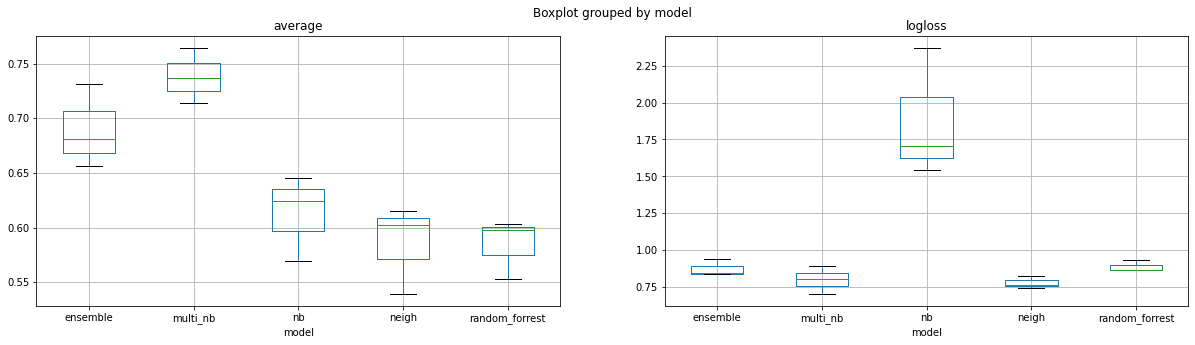

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

df.boxplot('average',by = 'model', ax=ax[0])
df.boxplot('logloss',by = 'model', ax=ax[1])



plt.show()